In [18]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *
from models import *

import pandas as pd
import tensorflow as tf
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool

In [19]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")

all_atms_feature_set = get_all_atms_feature_set(df, first_n = 50)

clustering_df = get_day_of_the_week_clustering_df(all_atms_feature_set, 'CashIn')
d = get_cluster(clustering_df, KMeans, 16, random_state=0)

all_atms_feature_set['ClusterId'] = all_atms_feature_set['AtmId'].map(d)
all_atms_feature_set.sort_index(inplace = True)
all_atms_feature_set

,CashIn,CashOut,AtmId,CashIn_average_7,CashIn_std_7,CashIn_average_14,CashIn_std_14,CashIn_average_30,CashIn_std_30,CashOut_average_7,...,ramazan_in_7_days,is_kurban,kurban_in_7_days,is_cocuk_bayrami,is_isci_bayrami,is_spor_bayrami,is_zafer_bayrami,is_cumhuriyet_bayrami,Special_Dates_Index,ClusterId
HistoryDate,,,,,,,,,,,,,,,,,,,,,
2016-02-10,55320.0,36480.0,26637,56012.857143,30650.689402,55142.857143,27056.402780,55019.000000,29327.560118,49010.000000,...,0,0,0,0,0,0,0,0,0,14
2016-02-10,15000.0,53750.0,33821,24338.571429,9148.007850,19855.714286,9790.658589,21724.666667,8132.775636,39934.285714,...,0,0,0,0,0,0,0,0,0,7
2016-02-10,56950.0,50690.0,27570,53068.571429,22026.296730,51317.142857,29940.934272,55690.666667,26638.304535,50448.571429,...,0,0,0,0,0,0,0,0,0,8
2016-02-10,22490.0,18690.0,27537,16298.571429,6843.655038,13690.000000,6796.517208,15460.333333,6292.875820,25232.857143,...,0,0,0,0,0,0,0,0,0,0
2016-02-10,32700.0,51560.0,33677,29270.000000,10106.723834,28701.428571,11345.919536,30223.666667,10275.577837,32550.000000,...,0,0,0,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-22,48025.0,59900.0,33831,54140.714286,9937.863381,55297.500000,13274.743044,50942.000000,14249.607593,72208.571429,...,0,0,0,0,0,0,0,0,0,9
2020-01-22,70900.0,37100.0,33833,72915.714286,22557.083224,70080.714286,24054.651626,72119.500000,25601.525222,50164.285714,...,0,0,0,0,0,0,0,0,0,6
2020-01-22,90185.0,62980.0,27727,96818.571429,45640.546640,96675.714286,39982.116813,100188.666667,34348.119055,65081.428571,...,0,0,0,0,0,0,0,0,0,9


In [20]:
categorical_features = ['Day_of_the_Week_Index', 'Day_of_the_Month_Index',
       'Week_of_the_Year_Index', 'Month_of_the_Year_Index', 'Is_Weekday',
       'Special_Dates_Index',
       'is_cocuk_bayrami', 'is_isci_bayrami', 'is_spor_bayrami',
       'is_zafer_bayrami', 'is_cumhuriyet_bayrami', 'ClusterId']
continuous_features   = ['CashIn_average_7', 'CashIn_std_7',
       'CashIn_average_14', 'CashIn_std_14', 'CashIn_average_30',
       'CashIn_std_30', 'CashOut_average_7', 'CashOut_std_7',
       'CashOut_average_14', 'CashOut_std_14', 'CashOut_average_30',
       'CashOut_std_30', 'CashIn_trend_7', 'CashOut_trend_7',
        'CashIn_t-1', 'CashIn_t-2', 'CashIn_t-3',
       'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6', 'CashIn_t-7', 'CashIn_t-8',
       'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11', 'CashIn_t-12',
       'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1', 'CashOut_t-2',
       'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5', 'CashOut_t-6',
       'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9', 'CashOut_t-10',
       'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13', 'CashOut_t-14',
       'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17', 'CashOut_t-18',
       'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21', 'CashOut_t-22',
       'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25', 'CashOut_t-26',
       'CashOut_t-27', 'CashOut_t-28', 'CashOut_t-29', 'CashOut_t-30',
       'CashOut_t-31', 'CashOut_t-32', 'CashOut_t-33', 'CashOut_t-34',
       'CashOut_t-35', 'CashOut_t-36', 'CashOut_t-37', 'CashOut_t-38',
       'CashOut_t-39', 'CashOut_t-40']

all_features = []
all_features.extend(categorical_features)
all_features.extend(continuous_features)

X = all_atms_feature_set[all_features]
y = all_atms_feature_set['CashIn']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

train_pool = Pool(data = X_train, label = y_train, cat_features=categorical_features)

In [21]:
cb = CatBoostRegressor()
cb.fit(train_pool, verbose=0)

In [33]:
"Train score: %.2f, test score: %.2f" % (cb.score(X_train, y_train), cb.score(X_test, y_test))

'Train score: 0.77, test score: 0.65'

In [22]:
feature_importance = cb.get_feature_importance(train_pool)

In [23]:
feature_importance.reshape(1,-1).shape

(1, 80)

<AxesSubplot:xlabel='features'>

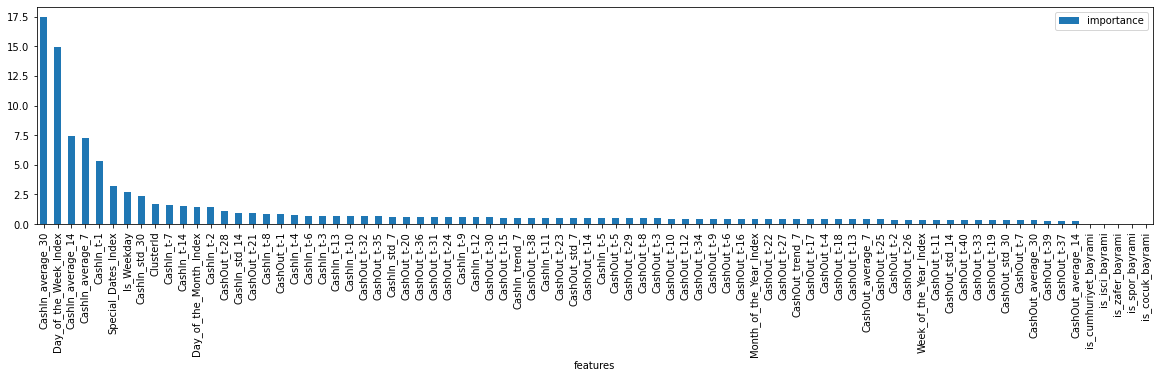

In [24]:
importance_df = pd.DataFrame({'features':all_features, 'importance':feature_importance})
importance_df.sort_values(by='importance', ascending=False, inplace=True)
importance_df.plot.bar(x='features', y='importance',figsize=(20,4))


## Plotting

In [25]:
from forecasting import get_error_with_freq
from plotting import draw_error_over_time

In [26]:
def draw_model_error(model, X, y_actual, error_freq='w', split_from=None):

    y_pred = pd.Series(model.predict(X).reshape(-1), index=y_actual.index)
    weekly_errors = get_error_with_freq(y_actual, y_pred, error_freq)
    draw_error_over_time(y_actual, y_pred, weekly_errors, split_from)
    print(weekly_errors.mean())

In [27]:
ATM_ID = 33821
atm_feature_set = all_atms_feature_set[all_atms_feature_set['AtmId'] == ATM_ID]
draw_model_error(cb, atm_feature_set[all_features], atm_feature_set['CashIn'], split_from=X_train.index[-1])

55.880909182077936
